# Lab 7: Evolutionary Algorithms

## Introduction

The aim of this lab exercise is to help improve your understanding of evolutionary algorithms, by giving you some practical experience in implementing and applying some of the algorithms discussed in the lectures.

By the end of this lab exercise, you will have
- implemented mutation, crossover and selection operators for Genetic Algorithms
- run Genetic Algorithms for the operators you implemented on a Mastermind game
- implemented two versions of ($\mu$+$\lambda$)-ES:  with and without self-adaptation of $\sigma$, and applied them to optimise the parameters of a lienar regressor
- implemented some of the components of MAP-Elites, and applied the algorithm to optimise a collection of quality and diverse configurations of a robot arm


## Genetic Algorithms

We will first explore Genetic Algorithms. You will try implement the Mastermind game as discussed in the lectures.

We will use this setup: each "peg" can be made up of one of 8 possible colours. The objective is to guess the secret colour combination of 4 pegs.

Since this exercise is aimed at improving your understanding, we will implement this section in pure Python (rather than NumPy), aiming for semantic clarity rather than implementation efficiency. You can of course choose to make your implementation more efficient and/or using NumPy if you prefer.

### Genotypes, Phenotypes and Fitness Function

We will first need to define the **genotypes** and **phenotypes** of the peg combination (we will use the term "instance" to describe this combination of 4 pegs). As presented in the lecture, the genotype is represented as a 12-bit binary string (3 bits for each of the 4 pegs). The phenotype is a sequence of 4 integers (for each peg), each representing a colour (0 to 7).

We will also need to define the **fitness function** measuring the quality of an instance. We will use the fitness function given in the lecture: $p_1 + 0.5 \times p_2$

where
- $p_1$ is the number of pegs with the correct colour in the correct position
- $p_2$ is the number of pegs with the correct colour but in the wrong position

To make it easier to understand the code, we will represent each instance in OOP style. I have provided two classes in the code below:
- `Instance` which stores the genotype, phenotype and fitness of each combination. You can use either of the following class methods to create a new instance:
  - `Instance.create_random()`: generates an instance with a random colour combination
  - `Instance.create_from_genotype()`: generates an instance from a genotype (12-bit string), e.g. `001111010000`.
- `Evaluator`, which takes an `Instance` as the reference solution, which is then used to compute the `fitness()` of an `Instance`.

I have implemented all these so that you can concentrate on the more interesting bits. Examine the code below, and ensure that you understand how to retreive the genotype/phenotype/fitness score for an instance -- you will need it later. Run the code to generate a random secret solution and an initial random population of 10.

In [4]:
import random

random.seed(60012)  # initialise with seed number

class Instance:
    def __init__(self, genotype=None, phenotype=None, fitness=0):
        self.genotype = genotype
        self.phenotype = phenotype
        self.fitness = fitness

    @classmethod
    def create_random(cls, n_pegs=4, n_bits_per_peg=3, fitness_evaluator=None):
        """ Generates a random Instance

        Args:
            n_pegs (int): number of pegs (defaults to 4)
            n_bits_per_peg (int): number of bits per peg (defaults to 3)
            fitness_evaluator (Evaluator): used for computing the fitness.
                                        The fitness of the returned Instance will
                                        be 0 if not provided.

        Returns:
            Instance
        """
        genotype = "".join(map(str, [random.getrandbits(1) for i in range(n_pegs*n_bits_per_peg)]))
        return Instance.create_from_genotype(genotype, n_pegs, fitness_evaluator)

    @classmethod
    def create_from_genotype(cls, genotype, n_pegs=4, fitness_evaluator=None):
        """ Generates an instance of Instance from a genotype bit string

        Args:
            genotype (str): a string representation of a genotype (e.g. '001111010000')
            n_pegs (int): number of pegs (defaults to 4)
            fitness_evaluator (Evaluator): used for computing the fitness.
                                        The fitness of the returned Instance will
                                        be 0 if not provided.

        Returns:
            Instance
        """
        phenotype = cls.genotype_to_phenotype(genotype, n_pegs)
        instance = Instance(genotype, phenotype)
        if fitness_evaluator is not None:
            fitness = fitness_evaluator.fitness(instance)
            instance.fitness = fitness
        return instance

    @classmethod
    def genotype_to_phenotype(cls, genotype, n_pegs=4):
        """ Converts a genotype bit string into a phenotype representation

        Args:
            genotype (str): a string representation of a genotype (e.g. '001111010000')
            n_pegs (int): number of pegs (defaults to 4)

        Returns:
            list : the phenotype
        """
        n_bits = round(len(genotype) / n_pegs)
        phenotype = []
        for i in range(n_pegs):
            bitstring = "".join(list(map(str, genotype[i*n_bits:i*n_bits+n_bits])))
            phenotype.append(int(bitstring, 2))
        return phenotype

    def __str__(self):
        return f"Instance({self.phenotype}, {self.genotype}, {self.fitness})"

    def __repr__(self):
        return str(self)


class Evaluator:
    def __init__(self, solution):
        """ Constructor

        Args:
            solution (Instance): the secret combination, for computing the fitness
        """
        self.solution = solution

    def fitness(self, instance):
        """ Compute the fitness score of an instance

        Args:
            instance (Instance): the instance

        Returns:
            float: the fitness score
        """
        p1 = 0
        instance_copy = instance.phenotype.copy()
        for i in range(len(instance.phenotype)):
            if instance.phenotype[i] == self.solution.phenotype[i]:
                p1 += 1
                instance_copy[i] = -1  # blank out exact matches

        p2 = 0
        for i in range(len(instance.phenotype)):
            # only count partial matches, skip exact matches
            if instance.phenotype[i] != self.solution.phenotype[i]:
                if self.solution.phenotype[i] in instance_copy:
                    p2 += 1

                    # blank out seen partial matches
                    # to handle duplicate numbers in solution
                    idx = instance_copy.index(self.solution.phenotype[i])
                    instance_copy[idx] = - 1

        return p1 + 0.5 * p2



def generate_solution(n_pegs=4, n_bits_per_peg=3):
    """ Initialise a secret combination """
    instance = Instance.create_random(n_pegs, n_bits_per_peg)

    # manually assign the fitness score to the instance
    evaluator = Evaluator(instance)
    instance.fitness = evaluator.fitness(instance)

    return instance


def initialise_population(population_size=10, n_pegs=4, n_bits_per_peg=3, fitness_evaluator=None):
    """ Initialise a population of random instances """
    population = []
    for i in range(population_size):
        population.append(Instance.create_random(n_pegs, n_bits_per_peg, fitness_evaluator))

    # sort the population by fitness score
    population.sort(key=lambda x:x.fitness, reverse=True)
    return population


n_pegs = 4
n_bits_per_peg = 3
population_size = 10

solution = generate_solution(n_pegs, n_bits_per_peg)

evaluator = Evaluator(solution)

initial_population = initialise_population(population_size, n_pegs, n_bits_per_peg, evaluator)

print("Solution:")
print(solution)

print()
print("Population:")
for instance in initial_population:
    print(instance)

Solution:
Instance([5, 5, 2, 0], 101101010000, 4.0)

Population:
Instance([5, 0, 3, 1], 101000011001, 1.5)
Instance([7, 3, 0, 0], 111011000000, 1.0)
Instance([1, 6, 2, 2], 001110010010, 1.0)
Instance([0, 1, 3, 6], 000001011110, 0.5)
Instance([6, 0, 1, 4], 110000001100, 0.5)
Instance([3, 0, 7, 3], 011000111011, 0.5)
Instance([3, 6, 3, 2], 011110011010, 0.5)
Instance([3, 4, 6, 7], 011100110111, 0.0)
Instance([1, 3, 7, 1], 001011111001, 0.0)
Instance([1, 6, 7, 7], 001110111111, 0.0)


### Mutation operator

We will take a bottom-up approach, and implement each of the operators first, before assembling them in our genetic algorithm.

You will first implement the mutation operator. Complete the `mutate()` function below to randomly flip the bits. You should return an `Instance` with the bits mutated.

In [9]:
def mutate(instance):
    """ Mutate an instance

    Args:
        instance (Instance): The instance to mutate

    Returns:
        Instance : The mutated instance
    """

    ## TODO: Mutate an instance

    mutated_bits = []
    ## For each bit in the genotype
    ##   - generate a random number between 0 and 1 uniformly
    ##   - if the number is less than 1/N, flip the bit
    ##     (N is the length of the genotype)
    ##
    for bit in instance.genotype:
      random_nbr = random.uniform(0, 1)
      if random_nbr < 1/len(instance.genotype):
        mutated_bits.append(str(1 - int(bit)))  # Flip the bit
      else:
        mutated_bits.append(bit)

    # join up the bits to form a single string
    mutated_genotype = "".join(mutated_bits)

    return Instance.create_from_genotype(mutated_genotype, n_pegs, evaluator)


## Test your code
instance = Instance.create_from_genotype("100111001000", n_pegs, evaluator)
print("original:")
print(instance)
print()

for _ in range(20):
    # try mutating the instance 20 times (it won't always be mutated)
    mutant = mutate(instance)
    print(mutant)


original:
Instance([4, 7, 1, 0], 100111001000, 1.0)

Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 5, 0, 3], 100101000011, 1.5)
Instance([4, 7, 0, 0], 100111000000, 1.0)
Instance([4, 7, 1, 4], 100111001100, 0.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([0, 3, 1, 1], 000011001001, 0.5)
Instance([4, 3, 1, 0], 100011001000, 1.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 5, 1, 0], 100101001000, 2.0)
Instance([5, 1, 1, 0], 101001001000, 2.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 7, 5, 0], 100111101000, 1.5)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([5, 6, 1, 0], 101110001000, 2.0)
Instance([4, 7, 1, 0], 100111001000, 1.0)
Instance([4, 5, 1, 2], 100101001010, 1.5)


### Crossover operator

Now, implement the crossover operator. Complete the `crossover()` function to swap the portion of bit strings between two instances at a random crossover. You should return a list of two new offspring instances.

In [10]:
def crossover(parent1, parent2):
    """ Crossover two instances at a random split point

    Args:
        parent1 (Instance)
        parent2 (Instance)

    Returns:
        list: a list of two instances of Instance resulting from the crossover
    """

    ## TODO: Crossover parents at random point to create two children
    ##   Choose a random split point
    ##   Generate two children by swapping at split points

    split_point = random.randint(1, len(parent1.genotype)-1)
    child1_genotype = parent1.genotype[:split_point] + parent2.genotype[split_point:]
    child2_genotype = parent2.genotype[:split_point] + parent1.genotype[split_point:]

    # Generate instances of Instance from the genotypes
    children = []
    children.append(Instance.create_from_genotype(child1_genotype, n_pegs, evaluator))
    children.append(Instance.create_from_genotype(child2_genotype, n_pegs, evaluator))
    return children


## Test code
parent1 = Instance.create_from_genotype("000100010011", n_pegs, evaluator)
parent2 = Instance.create_from_genotype("101111011001", n_pegs, evaluator)

print("Parents:")
print(parent1)
print(parent2)
print()

for _ in range(5):
    # Test crossover 5 times
    children = crossover(parent1, parent2)

    print("Children:")
    for child in children:
        print(child)
    print()


Parents:
Instance([0, 4, 2, 3], 000100010011, 1.5)
Instance([5, 7, 3, 1], 101111011001, 1.0)

Children:
Instance([0, 4, 3, 1], 000100011001, 0.5)
Instance([5, 7, 2, 3], 101111010011, 2.0)

Children:
Instance([0, 4, 3, 1], 000100011001, 0.5)
Instance([5, 7, 2, 3], 101111010011, 2.0)

Children:
Instance([0, 4, 2, 3], 000100010011, 1.5)
Instance([5, 7, 3, 1], 101111011001, 1.0)

Children:
Instance([0, 7, 3, 1], 000111011001, 0.5)
Instance([5, 4, 2, 3], 101100010011, 2.0)

Children:
Instance([1, 7, 3, 1], 001111011001, 0.0)
Instance([4, 4, 2, 3], 100100010011, 1.0)



### Selection operator

Finally, implement the selection operator. Complete the `select()` function to select `n_couples` couples, using either the tournament selection or biased roulette wheel (we will provide an implementation of both in the solutions).

In [11]:
def tournament(population, n_couples):
    parents = []
    for n in range(n_couples):
        # sample 4 instances (2 pairs)
        quartet = random.sample(population, 4)

        # choose the instance of each pair that has the higher fitness
        pair = [max(quartet[:2], key=lambda x:x.fitness),
                max(quartet[2:], key=lambda x:x.fitness)]
        parents.append(pair)

    return parents


def biased_roulette(population, n_couples):
    # get fitness scores to use as weights for the biased roulette
    fitness = [instance.fitness for instance in population]

    parents = []
    for n in range(n_couples):
        # select a pair based on the weights
        choices = random.choices(population, weights=fitness, k=2)
        parents.append(choices)

    return parents


# bind the select() function to one of the functions above
select = tournament
#select = biased_roulette

# test code
parents = select(initial_population, 4)
for parent in parents:
    print(parent)

[Instance([1, 6, 2, 2], 001110010010, 1.0), Instance([6, 0, 1, 4], 110000001100, 0.5)]
[Instance([6, 0, 1, 4], 110000001100, 0.5), Instance([3, 0, 7, 3], 011000111011, 0.5)]
[Instance([5, 0, 3, 1], 101000011001, 1.5), Instance([3, 0, 7, 3], 011000111011, 0.5)]
[Instance([5, 0, 3, 1], 101000011001, 1.5), Instance([7, 3, 0, 0], 111011000000, 1.0)]


### Genetic algorithm

You are now ready to run the Genetic algorithm with your selection, crossover, and mutation operators.

Examine the `repopulate()` function below to see how I assembled the operators you implemented earlier.

We will run the algorithm with the secret combination and the initial population generated earlier at the beginning of this section.

The code below will run the algorithm for 100 generations. Run the code, and examine the outputs to see how well the algorithm finds the solution.

In [12]:
def repopulate(population):
    new_generation = population[:2] # Elitism: Keep top 2 fittest
    parent_pairs = select(population, round(population_size/2)-1) # Choose remaining 4 couples
    for (parent1, parent2) in parent_pairs:
        children = crossover(parent1, parent2)
        mutated_children = [mutate(child) for child in children]
        new_generation.extend(mutated_children)
    new_generation.sort(key=lambda x:x.fitness, reverse=True)
    return new_generation


print("Secret combination:")
print(solution)

print()
print("Population:")
population = initial_population
for instance in population:
    print(instance)

random.seed(60012)

for iteration in range(100):
    print()
    print(f"Iteration: {iteration}")
    population = repopulate(population)
    for instance in population:
        print(instance)

Secret combination:
Instance([5, 5, 2, 0], 101101010000, 4.0)

Population:
Instance([5, 0, 3, 1], 101000011001, 1.5)
Instance([7, 3, 0, 0], 111011000000, 1.0)
Instance([1, 6, 2, 2], 001110010010, 1.0)
Instance([0, 1, 3, 6], 000001011110, 0.5)
Instance([6, 0, 1, 4], 110000001100, 0.5)
Instance([3, 0, 7, 3], 011000111011, 0.5)
Instance([3, 6, 3, 2], 011110011010, 0.5)
Instance([3, 4, 6, 7], 011100110111, 0.0)
Instance([1, 3, 7, 1], 001011111001, 0.0)
Instance([1, 6, 7, 7], 001110111111, 0.0)

Iteration: 0
Instance([5, 0, 3, 2], 101000011010, 2.0)
Instance([5, 0, 3, 0], 101000011000, 2.0)
Instance([5, 3, 0, 0], 101011000000, 2.0)
Instance([5, 0, 3, 1], 101000011001, 1.5)
Instance([5, 6, 3, 2], 101110011010, 1.5)
Instance([7, 3, 0, 0], 111011000000, 1.0)
Instance([3, 3, 0, 0], 011011000000, 1.0)
Instance([7, 0, 1, 1], 111000001001, 0.5)
Instance([6, 0, 3, 1], 110000011001, 0.5)
Instance([3, 6, 3, 1], 011110011001, 0.0)

Iteration: 1
Instance([5, 6, 2, 0], 101110010000, 3.0)
Instance([5, 0,

If you change the seed number above, you might arrive at a completely different set of solutions that may be suboptimal, and you may also need to increase the number of iterations.

## Evolutionary Strategies

We often need to deal with problems with continuous values, making genetic algorithms unsuitable for such problems.

In this section, we will explore Evolution Strategies (ES) which will allow us to optimise real valued parameters.

We will apply ES to optimise the parameters of a linear regressor $\hat{y} = wx_1+wx_2+b$.

For this section, we will go back to using NumPy as it will make it easier for us to implement ES.

The code below is copied from Lab 5. If you remember, it will generate a dataset of 100 instances from $4 x_1 + 2.5 x_2 + 1.5$. Therefore, the ideal solution is $w_1 = 4, w_2 = 2.5, b = 1.5$. We will use this dataset to compute the fitness of instances in ES.

Run the code below to generate the dataset.


In [14]:
import numpy as np
from numpy.random import default_rng

# Generating a random dataset from 4*x_1 + 2.5*x_2 + 1.5

seed = 60012
rg = default_rng(seed)
weights = np.array([4, 2.5, 1.5])
n_samples = 100
x_train = rg.random((n_samples, 2))*10.0
x_train = np.hstack((x_train, np.ones((n_samples, 1)))) # add bias constant
y_train = np.matmul(x_train, weights)


### Fitness function

Now, complete the function `fitness()` below to compute the fitness score of a population of weights, given training instances.

We will use the sum of squared difference across all training instances `x` as the fitness function.

As a convention, we want to **maximise** the fitness, so you should return the *negative* sum of squares.

Hint: You can modify the loss function from Lab 5. The main difference is that we will now need to compute the scores for multiple sets of weights, not just one set of weight.

In [15]:
import numpy as np

def fitness(w, x, y):
    """ The fitness function.

    Compute the fitness scores for each set of weights in the population,
    given the training instances x and ground truth labels y

    We will use the negative sum of squares across all training instances x as the fitness function.

    Args:
        w (np.ndarray): sized (P, D), where P is the population size, and D is the number of parameters including the bias
        x (np.ndarray): sized (N, D), where N is the number of training instances
        y (np.ndarray): sized (N,), the ground truth floating point labels

    Returns:
        np.ndarray: sized (P,), each element containing the fitness score for each set of weights in w
    """

    ### TODO: Complete the fitness function

    y_hat = np.matmul(w, x.T)
    return -np.sum((y_hat - y[:, np.newaxis].T)**2, axis=1)


## Test code
w = np.array([[4, 2.5, 1.5], [-1, 2, -3]])  # 2 sets of weights
x = np.array([[2, 3, 1], [1, 4, 1], [1, 2, 1], [3, 1, 1]]) # 4 training instances
y = np.array([17, 15.5, 10.5, 16]) # one ground truth label for each training instance
scores = fitness(w, x, y)
print(scores) # should return [0, -898.5]

[  -0.  -898.5]


### ($\mu$+$\lambda$)-ES

Let us now implement the basic ($\mu$+$\lambda$)-ES algorithm as described in the lectures.

Complete the code below (marked `TODO`) to implement the algorithm. Please refer to the lectures for the algorithm.

In [16]:
def print_population(population, fitness_scores, max_number=None):
    """ Prints out the instances in the population, sorted by descending fitness scores

    If max_number is given, then return the top max_number fittest instances
    """
    indices = np.argsort(-fitness_scores)
    population = population[indices, :]
    scores = fitness_scores[indices]

    if max_number is not None:
        n = max_number
    else:
        n = len(population)

    for (instance, score) in zip(population[:n], scores[:n]):
        print((instance, score))


## Set up the parameters

# lambda: number of offsprings (can't use "lambda" as it is a Python keyword)
lamb = 20

# mu: number of parents
mu = round(lamb / 5)

population_size = mu + lamb

# number of variables (including bias)
n_variables = 3

# std dev for generating offspring
sigma = 0.5

# Generate an initial population at random
# We will limit the search space to be between -10 and 10 for all variables
rg = np.random.default_rng(seed=60012)
population = rg.uniform(-10, 10, (population_size, n_variables))

for iteration in range(150):
    # compute the fitness scores
    scores = fitness(population, x_train, y_train)

    # select the mu fittest parents
    indices = np.argsort(-scores)[:mu] # sort it (the negative scores is a trick to sort by descending scores)
    parents = population[indices, :]  # x in the lecture

    # randomly sample lambda instances from parents
    random_indices = rg.choice(len(parents), lamb)

    # generate offsprings from the parents by adding some Gaussian noise to each
    offsprings = parents[random_indices, :] + rg.normal(0, sigma, (lamb, n_variables))

    # generate a new population by concatenating the parents and the offsprings
    population = np.vstack((parents, offsprings))

    ## Print out topN instances in population for inspection
    print("\nIteration: ", iteration)
    scores = fitness(population, x_train, y_train)
    print_population(population, scores, max_number=3)

print("\nFinal population: ")
scores = fitness(population, x_train, y_train)
print_population(population, scores)


Iteration:  0
(array([ 5.00108999,  2.52271104, -1.13633906]), -1687.50938948097)
(array([ 5.24728384,  2.14657977, -1.33519053]), -1819.536454573371)
(array([ 5.31742574,  1.14779116, -0.97597006]), -3454.2311448540104)

Iteration:  1
(array([ 4.49827204,  2.42014684, -0.7738545 ]), -183.48189071720842)
(array([ 4.59621452,  2.41758951, -1.73563202]), -265.0558597586162)
(array([ 4.52283135,  2.16174501, -1.95298716]), -802.1243569563393)

Iteration:  2
(array([ 4.36160877,  2.62221685, -1.32733959]), -106.1174981898186)
(array([ 4.49827204,  2.42014684, -0.7738545 ]), -183.48189071720842)
(array([ 4.59621452,  2.41758951, -1.73563202]), -265.0558597586162)

Iteration:  3
(array([ 4.32749932,  2.55183077, -0.95572799]), -88.05337421649968)
(array([ 4.36160877,  2.62221685, -1.32733959]), -106.1174981898186)
(array([ 4.32557464,  2.78973609, -1.90622335]), -152.1556333752666)

Iteration:  4
(array([ 4.32749932,  2.55183077, -0.95572799]), -88.05337421649968)
(array([ 4.36160877,  2.62

### ($\mu$+$\lambda$)-ES with self-adaptation

A challenge for ($\mu$+$\lambda$)-ES is to decide on an optimal fixed $\sigma$.

This can be addressed by adapting the $\sigma$ over time, as described in the lectures. Let us now implement this version of the ($\mu$+$\lambda$)-ES algorithm with self-adaptation of $\sigma$, as described in the lectures.

The implementation will be similar to the one before, except that you will now have to keep track of the $\sigma$ for each instance in the population. To make it easier to read, we will keep track of the $\sigma$s with a variable that is separate from the weights.

In [17]:
def print_population(population, sigmas, fitness_scores, max_number=None):
    """ Prints out the instances in the population (and sigmas), sorted by descending fitness scores

    If max_number is given, then return the top max_number fittest instances
    """
    indices = np.argsort(-fitness_scores)
    population = population[indices, :]
    sigmas = sigmas[indices]
    scores = fitness_scores[indices]

    if max_number is not None:
        n = max_number
    else:
        n = len(population)

    for (instance, sigma, score) in zip(population[:n], sigmas[:n], scores[:n]):
        print((instance, sigma, score))


## Set up the parameters

# lambda: number of offsprings (can't use "lambda" as it is a Python keyword)
lamb = 20

# mu: number of parents
mu = round(lamb / 5)

population_size = mu + lamb

# number of variables (including bias)
n_variables = 3

# heuristic for learning rate
learning_rate = 1 / np.sqrt(n_variables)

# Generate an initial population at random
# We will limit the search space to be between -10 and 10 for all variables
rg = np.random.default_rng(seed=60012)
population = rg.uniform(-10, 10, (population_size, n_variables))
sigmas = 0.5 * np.ones((population_size, 1)) # initialise std dev for each instance to 0.5

for iteration in range(150):
    # compute the fitness scores
    scores = fitness(population, x_train, y_train)

    # select the mu fittest parents
    indices = np.argsort(-scores)[:mu] # sort it (the negative scores is a trick to sort by descending scores)
    parents = population[indices, :]  # x in the lecture
    parents_sigmas = sigmas[indices]  # sigma of parents

    # randomly sample lambda instances from parents
    random_indices = rg.choice(len(parents), lamb)

    # generate offsprings from the parents by adding some Gaussian noise to each
    offsprings_sigmas =  parents_sigmas[random_indices] * np.exp(learning_rate * rg.normal(0, 1, (lamb, 1)))
    offsprings = parents[random_indices, :] + offsprings_sigmas * rg.normal(0, 1, (lamb, n_variables))

    # generate a new population by concatenating the parents and the offsprings
    population = np.vstack((parents, offsprings))
    sigmas = np.vstack((parents_sigmas, offsprings_sigmas))

    ### Print out topN instances in population for inspection
    #print("\nIteration: ", iteration)
    #scores = fitness(population, x_train, y_train)
    #print_population(population, sigmas, scores, max_number=3)

print("\nFinal population: ")
scores = fitness(population, x_train, y_train)
print_population(population, sigmas, scores)



Final population: 
(array([4.01084463, 2.50690387, 1.39125657]), array([0.000366]), -0.1399259758085384)
(array([4.01024633, 2.50755496, 1.39140498]), array([0.00022592]), -0.14003861084596889)
(array([4.01061582, 2.50746107, 1.39135952]), array([0.0002041]), -0.14036385278541444)
(array([4.01066085, 2.50699768, 1.39106156]), array([0.00050948]), -0.14037766172028127)
(array([4.01067759, 2.50686004, 1.39086872]), array([0.00070366]), -0.14096951239080785)
(array([4.01054604, 2.50759905, 1.39108223]), array([0.000294]), -0.14125942616255519)
(array([4.01048999, 2.50678724, 1.39094292]), array([0.00030078]), -0.14126867421929445)
(array([4.0102076 , 2.50770113, 1.3907611 ]), array([0.00029807]), -0.14190294803459633)
(array([4.01096076, 2.50669554, 1.39051203]), array([0.00038344]), -0.14193664103838563)
(array([4.01097599, 2.50747475, 1.39111296]), array([0.00071452]), -0.14223438593692073)
(array([4.01081133, 2.50752491, 1.39079722]), array([0.00033191]), -0.14234244322266207)
(array(

You should be able to observe that the values of $\sigma$ is much smaller in later generations compared to the initial stages.

## MAP-Elites

Sometimes, we would like to optimise not just for one single solution, but for a collection of diverse and high-quality solutions. These are Quality-Diversity optimisation algorithms. In this section, we will try to implement and apply the simple yet effective MAP-Elites algorithm.

### Robotic arms

We will apply MAP-Elites to find a collection of diverse and high-quality configurations for a robotic arm.

We will assume that the robotic arm has four 'joints' made up of motors that can rotate each arm segment by between -180 to 180 degrees (or $-\pi$ to $\pi$ radians). Each segment is 0.25m long, and the maximum length of the whole arm is 1m (when fully stretched out). The base of the arm is attached at $(0, 0)$, and the output that we are interested in is the $(x,y)$ coordinates of the arm tip (the *effector*) in **behavioural descriptor** space.

The **phenotype** of the robot arm is a vector of angles (between $-\pi$ and $\pi$) for each of the joints.

The **genotype** is equivalent to the phenotype normalised to be between $0$ and $1$.

The same $(x, y)$ might be reached by multiple arm configurations (different angle combinations), so we would also like to know which of these configurations is optimal. As the **fitness function**, we would like the angles of the joints to have minimal variance (we prefer configurations that require minimal movements and a more uniform spread across joints so that we do not overstrain a single motor). As we need to *maximise* our fitness scores, we compute the negated variance.

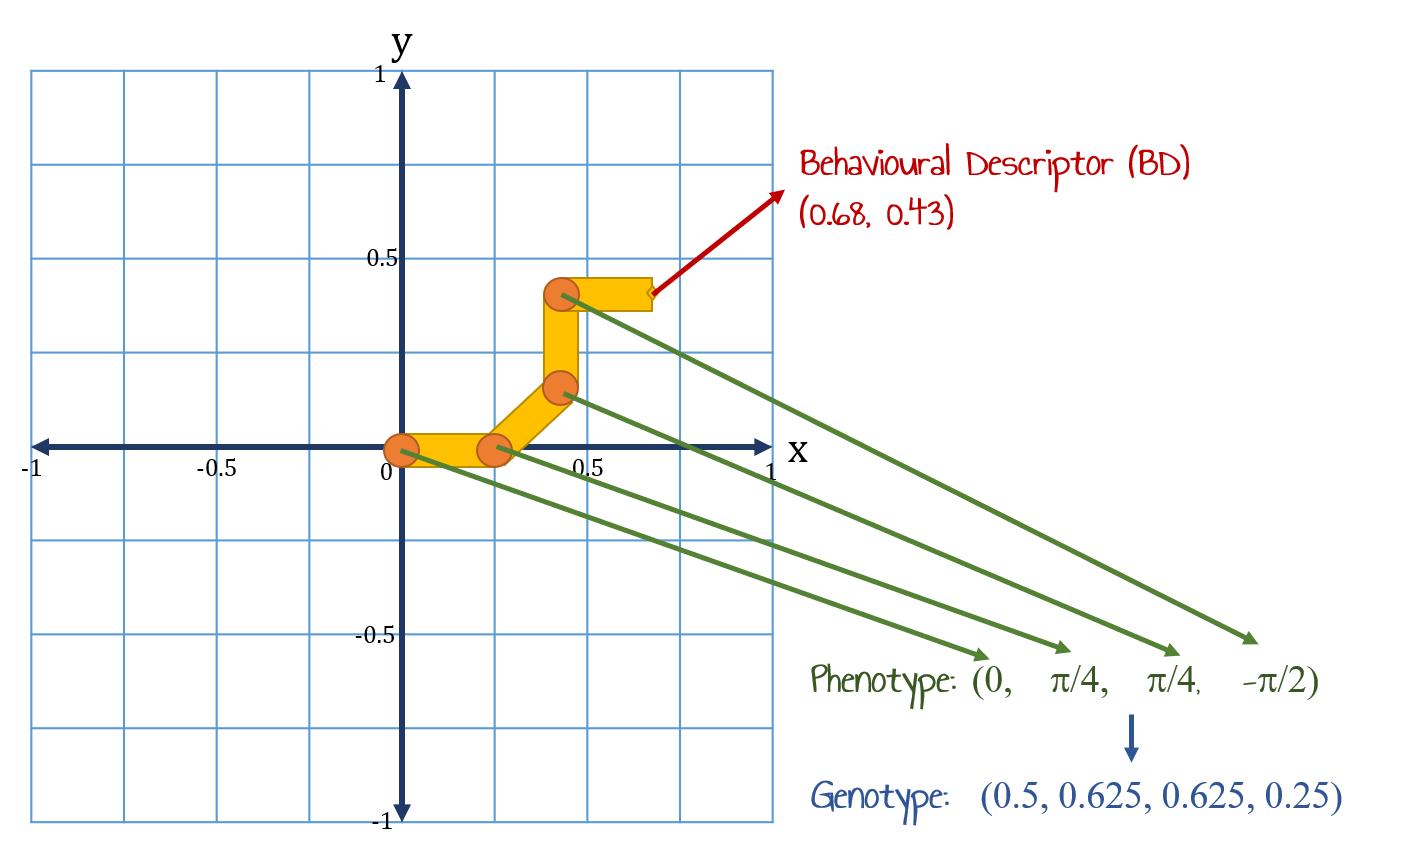


### Genotype, Phenotype, Behavioural Descriptor, Fitness

Like in genetic algorithms section earlier, we will represent a potential solution as an instance of the `Instance` class. It contains the following properties:
- `genotype`: the normalised angles (between 0 and 1) of the 4 joints
- `phenotype` (read-only): the angles (in radians) of the 4 joints
- `descriptor` (read-only): the behavioural descriptor: the (x, y) coordinates of the robot arm's tip
- `fitness` (read-only): the fitness score (the negated variance of the angles)

It also contains the following class methods to create a new instance:
  - `Instance.create_random()`: generates a random instance
  - `Instance.create_from_genotype()`: generates an instance from a list of 4 normalised angles

There is no need to understand the details of the implementation (or the `Arm` class). You only need to understand how the properties of `Instance` above are represented and how to use the `Instance` class.

Run the code below. Examine the example usage and output to understand how to use the `Instance` class.

In [18]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# The Arm class is copied from https://github.com/resibots/pymap_elites
class Arm:
    def __init__(self, lengths):
        self.n_dofs = len(lengths)
        self.lengths = np.concatenate(([0], lengths))
        self.joint_xy = []

    def fw_kinematics(self, p):
        assert(len(p) == self.n_dofs)
        p = np.append(p, 0)
        self.joint_xy = []
        mat = np.matrix(np.identity(4))
        for i in range(0, self.n_dofs + 1):
            m = [[math.cos(p[i]), -math.sin(p[i]), 0, self.lengths[i]],
                 [math.sin(p[i]),  math.cos(p[i]), 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            mat = mat * np.matrix(m)
            v = mat * np.matrix([0, 0, 0, 1]).transpose()
            self.joint_xy += [v[0:2].A.flatten()]
        return self.joint_xy[self.n_dofs], self.joint_xy


class Instance:
    def __init__(self, n_joints=4, genotype=None):
        """ Constructor for the Instance class

        Args:
            n_joints (int): degrees of freedom of arm (defaults to 4)
            genotype (np.ndarray): sized (n_joints, ), the angle (between 0 and 1) for each joint
                                    randomly generated if not given (default)
        """
        self.arm = Arm(np.ones((n_joints, )) / n_joints)
        self.n_joints = n_joints

        if genotype is not None:
            assert n_joints == len(genotype)
            self.genotype = genotype
        else:
            rg = np.random.default_rng()
            self.genotype = rg.random(n_joints)

    @property
    def phenotype(self):
        """ Convert genotype from [0, 1] range to [-pi, pi] """
        return (self.genotype - 0.5) * 2 * math.pi

    @property
    def fitness(self):
        """ Fitness score: negative variance of angles """
        return -np.std(self.phenotype)**2

    @property
    def descriptor(self):
        """ Behavioural descriptor: 2D Cartesian coordinate (x, y) """
        desc, _ = self.arm.fw_kinematics(self.phenotype)
        return desc

    @classmethod
    def create_random(cls, n_joints=4):
        """ Generates a random Instance

        Returns:
            Instance
        """
        return Instance(n_joints)

    @classmethod
    def create_from_genotype(cls, genotype):
        """ Generates an instance of Instance from a genotype

        Args:
            genotype (np.ndarray): sized (n_joints, ), the angle (between 0 and 1) for each joint

        Returns:
            Instance
        """
        return Instance(len(genotype), genotype)

    def __str__(self):
        return f"Instance(PT={self.phenotype}, GT={self.genotype}, BD={self.descriptor}, F={self.fitness})"

    def __repr__(self):
        return str(self)

# Print out floats with 4 d.p.
np.set_printoptions(precision=4)

## Example usage
# create an instance from a genotype
instance = Instance.create_from_genotype(np.array([0, 0.5, 0.75, 1]))
print(instance)
print("Genotype: ", instance.genotype)
print("Phenotype: ", instance.phenotype)
print("Behavioural descriptor: ", instance.descriptor)
print("Fitness score: ", instance.fitness)
print()

# create random instances - 2 ways
n_joints = 4
print(Instance(n_joints))
print(Instance.create_random(n_joints))

# more examples
print(Instance.create_from_genotype(np.array([0, 0])))  # base -180 degrees, second joint -180 degrees (points back to the base (0,0))
print(Instance.create_from_genotype(np.array([0.5, 0.5])))  # straight arm pointing right
print(Instance.create_from_genotype(np.array([0.5, 0.625, 0.625, 0.25])))  # the configuration in the diagram above

Instance(PT=[-3.1416  0.      1.5708  3.1416], GT=[0.   0.5  0.75 1.  ], BD=[-5.0000e-01 -5.5511e-17], F=-5.397439906845743)
Genotype:  [0.   0.5  0.75 1.  ]
Phenotype:  [-3.1416  0.      1.5708  3.1416]
Behavioural descriptor:  [-5.0000e-01 -5.5511e-17]
Fitness score:  -5.397439906845743

Instance(PT=[-3.0235 -0.5611  0.285   0.371 ], GT=[0.0188 0.4107 0.5454 0.559 ], BD=[-0.9654  0.0642], F=-1.882793402563346)
Instance(PT=[-0.4607 -1.7207  0.4465  2.1354], GT=[0.4267 0.2261 0.5711 0.8399], BD=[ 0.27   -0.4651], F=-1.9730533370546777)
Instance(PT=[-3.1416 -3.1416], GT=[0 0], BD=[0.0000e+00 6.1232e-17], F=-0.0)
Instance(PT=[0. 0.], GT=[0.5 0.5], BD=[1. 0.], F=-0.0)
Instance(PT=[ 0.      0.7854  0.7854 -1.5708], GT=[0.5   0.625 0.625 0.25 ], BD=[0.6768 0.4268], F=-0.9252754126021273)


### The MAP-Elites Grid

We will also prepare ourselves so that we can implement the MAP-Elites grid later.

The `descriptor_to_bin()` function below maps a floating point behavioural descriptor $(x, y)$ to a bin `(row, col)` in the discretised behavioural descriptor space.  

Run the code below, and examine the inputs and outputs of the test code. Note the differences in the indexing for the grid (the index `(0,0)` is at the top-left) and the behaviour descriptor space ($(0,0)$ is in the middle of the grid). Also remember that grid rows are $y$ and columns are $x$ (a detail that you will need to remember when dealing with image coordinates vs. Cartesian coordinate systems).

In [19]:
def descriptor_to_bin(descriptor, n_cells=100):
    """ Returns the (row, col) index of the grid for a behavioural descriptor (x, y)

    Args:
        descriptor (np.ndarray): sized (2,), the behavioural descriptor (x, y)
        n_cells (int): number of cells in each row/column of the grid

    Return:
        tuple: (row, col) The row and column index (starting from 0) for the descriptor in the grid
    """

    # Divide behavioural descriptor space into grid cells
    xbins = np.linspace(-1, 1, n_cells+1)  # x is left to right
    ybins = np.linspace(1, -1, n_cells+1)  # y is bottom to top

    # Get the indices of the cell
    x_index = np.digitize(descriptor[0], xbins) - 1
    y_index = np.digitize(descriptor[1], ybins, right=True) - 1

    # Handle edge cases
    if x_index < 0:
        x_index = 0
    if x_index >= n_cells:
        x_index = n_cells - 1
    if y_index < 0:
        y_index = 0
    if y_index >= n_cells:
        y_index = n_cells - 1

    # note that y = rows, x = cols in the grid
    return (y_index, x_index)

## Test function
print(descriptor_to_bin([-1,-1], n_cells=10))  # bottom-left (row 9, column 0)
print(descriptor_to_bin([1,1], n_cells=10))    # top-right (row 0, column 9)
print(descriptor_to_bin([0,0], n_cells=10))    # centre (row 5, column 5)
print(descriptor_to_bin([-1,1], n_cells=10))   # top-left (row 0, column 0)
print(descriptor_to_bin([1,-1], n_cells=10))   # bottom-right (row 9, column 9)


(9, 0)
(0, 9)
(5, 5)
(0, 0)
(9, 9)


### The Archive

Let's initialise our archive with some initial instances. For simplicity, we will add a single instance (generated at random) to the archive.

The `archive` will be a Python `dict` that has the bin index `(row, col)` as the key, and an instance of `Instance` as its value.

I have also provided a `visualise_grid()` function to visualise the archive. If you run the code, you will see a single red spot representing the fitness value of the single instance.


{(23, 22): Instance(PT=[ 1.0981 -2.9256 -3.0182  2.5016], GT=[0.6748 0.0344 0.0196 0.8981], BD=[-0.091   0.0497], F=-5.9397129187416065)}


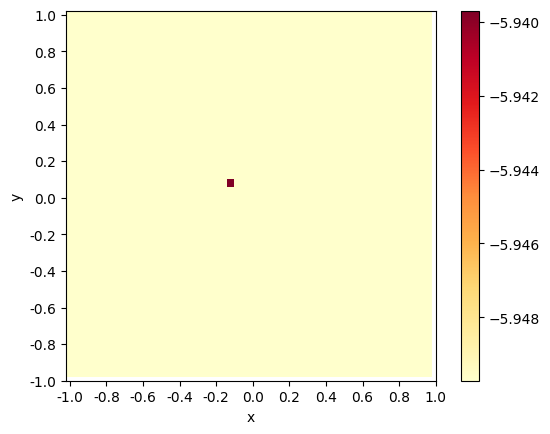

In [20]:
# The archive
# where the key is the bin index e.g. (1, 3)
# and the value is an instance of Instance
archive = {}

n_joints = 4   # number of joints on the robot's arm
n_cells = 50  # (n_cells x n_cells) BD grid

# create random instance
instance = Instance.create_random(n_joints)

# get the bin location in the grid for this instance
bin_index = descriptor_to_bin(instance.descriptor, n_cells)

# add it to the archive, indexing it by the bin location
archive[bin_index] = instance

print(archive)

def visualise_grid(archive, n_cells):
    """ Visualise the grid """
    minval = min([instance.fitness for instance in archive.values()])
    grid = np.ones((n_cells, n_cells)) * (minval - 0.01)
    for (r, c), instance in archive.items():
        grid[r, c] = instance.fitness

    plt.imshow(grid, cmap=matplotlib.cm.YlOrRd)
    xlabels = [-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]
    plt.xticks(ticks=np.linspace(0, n_cells, 11), labels=xlabels)
    plt.xlabel("x")
    ylabels = xlabels[::-1]
    plt.yticks(ticks=np.linspace(0, n_cells, 11), labels=ylabels)
    plt.ylabel("y")
    plt.colorbar()
    plt.show()

visualise_grid(archive, n_cells)


### Selector

Now, we will need a selector to select the instance from the archive. The instance will later be mutated and evaluated in the next generation in the MAP-Elites algorithm.

We will use a simple selector: a uniform random selection over the instances in the archive.

Here is an easy implementation task for you. Complete the `select()` function to select a random instance (uniformly) from the archive, and return the instance.


In [21]:
def select(archive):
    """ Select a random instance (uniformly) from the archive, and return the instance

    Args:
        archive (dict): key is the (row, col) index in the grid, the value is an Instance

    Returns:
        Instance
    """

    ## TODO: return a random instance from the archive
    rg = np.random.default_rng()
    random_index = rg.integers(len(archive))
    return list(archive.values())[random_index]


### Test code
test_archive = {}
for _ in range(5):
    instance = Instance.create_random(n_joints)
    bin_index = descriptor_to_bin(instance.descriptor, n_cells)
    test_archive[bin_index] = instance

print("Archive:")
for (key, val) in test_archive.items():
    print(f"{key} -> {val}")

selected_instance = select(test_archive)
print("\nSelected:")
print(selected_instance)

Archive:
(28, 20) -> Instance(PT=[-2.3009  0.2944  2.3159  1.8759], GT=[0.1338 0.5469 0.8686 0.7986], BD=[-0.1783 -0.1325], F=-3.267368709356974)
(38, 23) -> Instance(PT=[-0.4112 -1.2128 -1.7346  1.6186], GT=[0.4345 0.307  0.2239 0.7576], BD=[-0.0704 -0.5421], F=-1.6279750866604095)
(31, 9) -> Instance(PT=[-2.4936 -0.4334 -0.988   2.3007], GT=[0.1031 0.431  0.3427 0.8662], BD=[-0.6334 -0.2793], F=-3.0058509416896877)
(15, 4) -> Instance(PT=[ 2.4561 -0.0881  1.0861 -0.831 ], GT=[0.8909 0.486  0.6729 0.3677], BD=[-0.8274  0.3799], F=-1.5475652691691566)
(24, 33) -> Instance(PT=[-0.1719  2.8411 -1.9987 -1.7573], GT=[0.4726 0.9522 0.1819 0.2203], BD=[0.3359 0.0051], F=-3.722268434238513)

Selected:
Instance(PT=[-2.3009  0.2944  2.3159  1.8759], GT=[0.1338 0.5469 0.8686 0.7986], BD=[-0.1783 -0.1325], F=-3.267368709356974)


### Mutation

The next step is to mutate the selected instance.

For each angle in the **genotype** of the instance, you can simply add some random noise drawn from a Normal distribution. You can use mean=0 and sigma=0.1.

You may also need to clip the boundaries of each of the angle to ensure that it is between 0 and 1.

In [22]:
def mutate(instance, sigma=0.1):
    """ Mutate the genotype of an instance with a random gaussian noise

    Args:
        instance (Instance): the instance to mutate
        sigma (float): standard deviation for the Gaussian noise. Defaults to 0.1

    Returns:
        Instance: the mutated instance
    """

    # TODO: mutate the genotype of instance by adding a random gaussian noise
    # with mean=0 and stdev=sigma
    noise = np.random.normal(0, sigma, len(instance.genotype))
    new_genotype = instance.genotype + noise

    # limit the range to be between 0 and 1
    new_genotype[new_genotype < 0] = 0.
    new_genotype[new_genotype > 1] = 1.

    return Instance.create_from_genotype(new_genotype)


# Test code
instance = Instance.create_random(n_joints)
print("Original: ", instance)
mutated_instance = mutate(instance)
print("Mutated: ", mutated_instance)

Original:  Instance(PT=[-1.1924  1.7643 -0.0313 -1.6828], GT=[0.3102 0.7808 0.495  0.2322], BD=[ 0.6208 -0.1958], F=-1.7602804739654387)
Mutated:  Instance(PT=[-2.3632  1.1245 -0.1887 -2.098 ], GT=[0.1239 0.679  0.47   0.1661], BD=[-0.2926 -0.5657], F=-2.0447885720003836)


### Potential addition to archive

The final component that needs implementing is the addition of a candidate instance to the archive.

As described in the lecture, once you figure out to which grid cell a behavioural descriptor belongs, you then add the new instance to the grid cell. If the grid cell is already occupied, then replace the existing solution only if the fitness of the new instance is larger than the fitness of the existing one.

Complete `add_instance_to_archive()` below to  accomplish this.

In [23]:
def add_instance_to_archive(instance, archive, n_cells=100):
    """ Add instance to archive, but only if the instance is fit enough!

    Map the instance's behavioural descriptor to its grid cell.
    If the grid cell is unoccupied, add the instance.
    If the instance is fitter than an existing solution occupying the same grid
    cell, replace the existing solution with the new instance.

    Args:
        instance (Instance): a candidate instance to possibly add to archive
        archive (dict): key is the (row, col) index in the grid, the value is an Instance
        n_cells (int): number of cells in grid (default: 100)

    Returns:
        archive (dict): the updated archive
    """

    # get the bin location in the grid for this instance
    bin_index = descriptor_to_bin(instance.descriptor, n_cells)

    if bin_index in archive:
        if instance.fitness > archive[bin_index].fitness:
            archive[bin_index] = instance
    else:
        # add straight to archive if cell is not occupied
        archive[bin_index] = instance

    return archive


## Test code
test_archive = {}
instance = Instance.create_from_genotype(np.array([0.1, 0.2, 0.3, 0.4]))
bin = descriptor_to_bin(instance.descriptor, n_cells)
test_archive[bin] = instance
instance = Instance.create_from_genotype(np.array([0, 0.5, 0.5, 1]))
bin = descriptor_to_bin(instance.descriptor, n_cells)
test_archive[bin] = instance

print("First test:")
print("Archive:")
for (key, val) in test_archive.items():
    print(f"{key} -> {val}")

instance = Instance.create_from_genotype(np.array([0.01, 0.48, 0.56, 0.99]))
test_archive = add_instance_to_archive(instance, test_archive, n_cells)

print("After addition (old instance should replaced by new instance):")
for (key, val) in test_archive.items():
    print(f"{key} -> {val}")

test_archive = {}
instance = Instance.create_from_genotype(np.array([0.1, 0.2, 0.3, 0.4]))
bin = descriptor_to_bin(instance.descriptor, n_cells)
test_archive[bin] = instance
instance = Instance.create_from_genotype(np.array([0.01, 0.48, 0.56, 0.99]))
bin = descriptor_to_bin(instance.descriptor, n_cells)
test_archive[bin] = instance

print("\nSecond test:")
print("Archive:")
for (key, val) in test_archive.items():
    print(f"{key} -> {val}")

instance = Instance.create_from_genotype(np.array([0, 0.5, 0.5, 1]))
test_archive = add_instance_to_archive(instance, test_archive, n_cells)

print("After addition (test_archive should stay the same):")
for (key, val) in test_archive.items():
    print(f"{key} -> {val}")



First test:
Archive:
(19, 29) -> Instance(PT=[-2.5133 -1.885  -1.2566 -0.6283], GT=[0.1 0.2 0.3 0.4], BD=[0.1727 0.2378], F=-0.4934802200544679)
(25, 12) -> Instance(PT=[-3.1416  0.      0.      3.1416], GT=[0.  0.5 0.5 1. ], BD=[-5.0000e-01 -9.1849e-17], F=-4.934802200544679)
After addition (old instance should replaced by new instance):
(19, 29) -> Instance(PT=[-2.5133 -1.885  -1.2566 -0.6283], GT=[0.1 0.2 0.3 0.4], BD=[0.1727 0.2378], F=-0.4934802200544679)
(25, 12) -> Instance(PT=[-3.0788 -0.1257  0.377   3.0788], GT=[0.01 0.48 0.56 0.99], BD=[-0.4946 -0.0151], F=-4.7749146092470305)

Second test:
Archive:
(19, 29) -> Instance(PT=[-2.5133 -1.885  -1.2566 -0.6283], GT=[0.1 0.2 0.3 0.4], BD=[0.1727 0.2378], F=-0.4934802200544679)
(25, 12) -> Instance(PT=[-3.0788 -0.1257  0.377   3.0788], GT=[0.01 0.48 0.56 0.99], BD=[-0.4946 -0.0151], F=-4.7749146092470305)
After addition (test_archive should stay the same):
(19, 29) -> Instance(PT=[-2.5133 -1.885  -1.2566 -0.6283], GT=[0.1 0.2 0.3 0

### Algorithm

Finally, we can assemble the components to implement MAP-Elites. The algorithm is straightforward if you have implemented all the components earlier.

Run the code below (it may take a while to run). Your output should look something like the figure below (darker red = fitter). This heatmap shows all the points the arm can reach, and the best fitness score to date for each position.

Play around with the **number of generations** and also the **number of cells** in the grid and observe the effects.

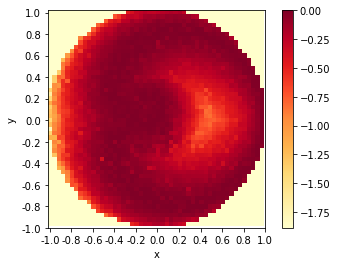

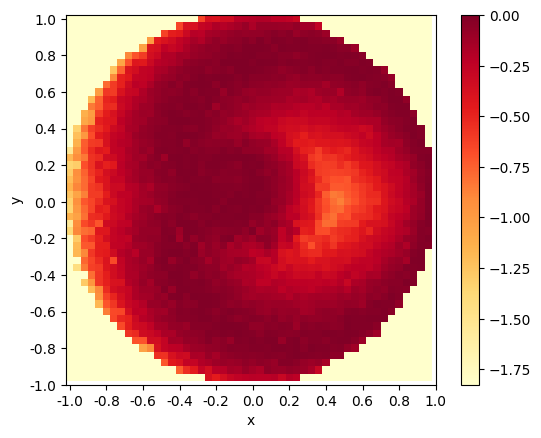

In [24]:
archive = {}

n_joints = 4
n_cells = 50

mutation_sigma = 0.1

# add a random instance to the archive
instance = Instance.create_random(n_joints)
archive = add_instance_to_archive(instance, archive, n_cells)

n_generations = 50000
for iteration in range(n_generations):
    instance = select(archive)
    instance = mutate(instance, mutation_sigma)
    archive = add_instance_to_archive(instance, archive, n_cells)

visualise_grid(archive, n_cells)

## Summary

You have applied Genetic Algorithms to solve a game of Mastermind, by implementing mutation, crossover and selection operators for the algorithm. You have also had some practical experience implementing some Evolutionary Strategies, namely ($\mu$+$\lambda$)-ES and its self-adaptive variant, and applied it to optimise the parameters of a linear regressor. Finally, you have implemented different components of MAP-Elites and applied MAP-Elites to optimise the quality and diversity of robot arm configurations.

Hopefully these exercises have allowed you to improve your practical understanding of Evolutionary Algorithms.

This is also the last lab exercise - hope you find them helpful for deepening your understanding of the course. Let us know if you have any feedback!
